In [2]:
# Libraries used for this project:

import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from datetime import datetime
import re

# The dateutil module provides powerful extensions to the standard datetime module.
from dateutil.relativedelta import relativedelta

# Conection to MyQSL with SQLAlchemy
from sqlalchemy import create_engine

# Usign geopy we are going to check in which continent the accidents happened.
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# Extension of Python package pycountry providing conversion functionalities
import pycountry_convert as pc

# Progress bar for Python
from tqdm import tqdm
tqdm.pandas()


In [33]:
# We open the cv to have a look of the initial information.
crashes = pd.read_csv('AccidentesAviones.csv')

In [34]:
# Shape of our initial dataframe.
crashes.shape

(5008, 18)

In [35]:
# Resume of our initial data.
crashes.info()

# As we can see our data in complete. Nevertheless, there are records without data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Unnamed: 0              5008 non-null   int64 
 1   fecha                   5008 non-null   object
 2   HORA declarada          5008 non-null   object
 3   Ruta                    5008 non-null   object
 4   OperadOR                5008 non-null   object
 5   flight_no               5008 non-null   object
 6   route                   5008 non-null   object
 7   ac_type                 5008 non-null   object
 8   registration            5008 non-null   object
 9   cn_ln                   5008 non-null   object
 10  all_aboard              5008 non-null   object
 11  PASAJEROS A BORDO       5008 non-null   object
 12  crew_aboard             5008 non-null   object
 13  cantidad de fallecidos  5008 non-null   object
 14  passenger_fatalities    5008 non-null   object
 15  crew

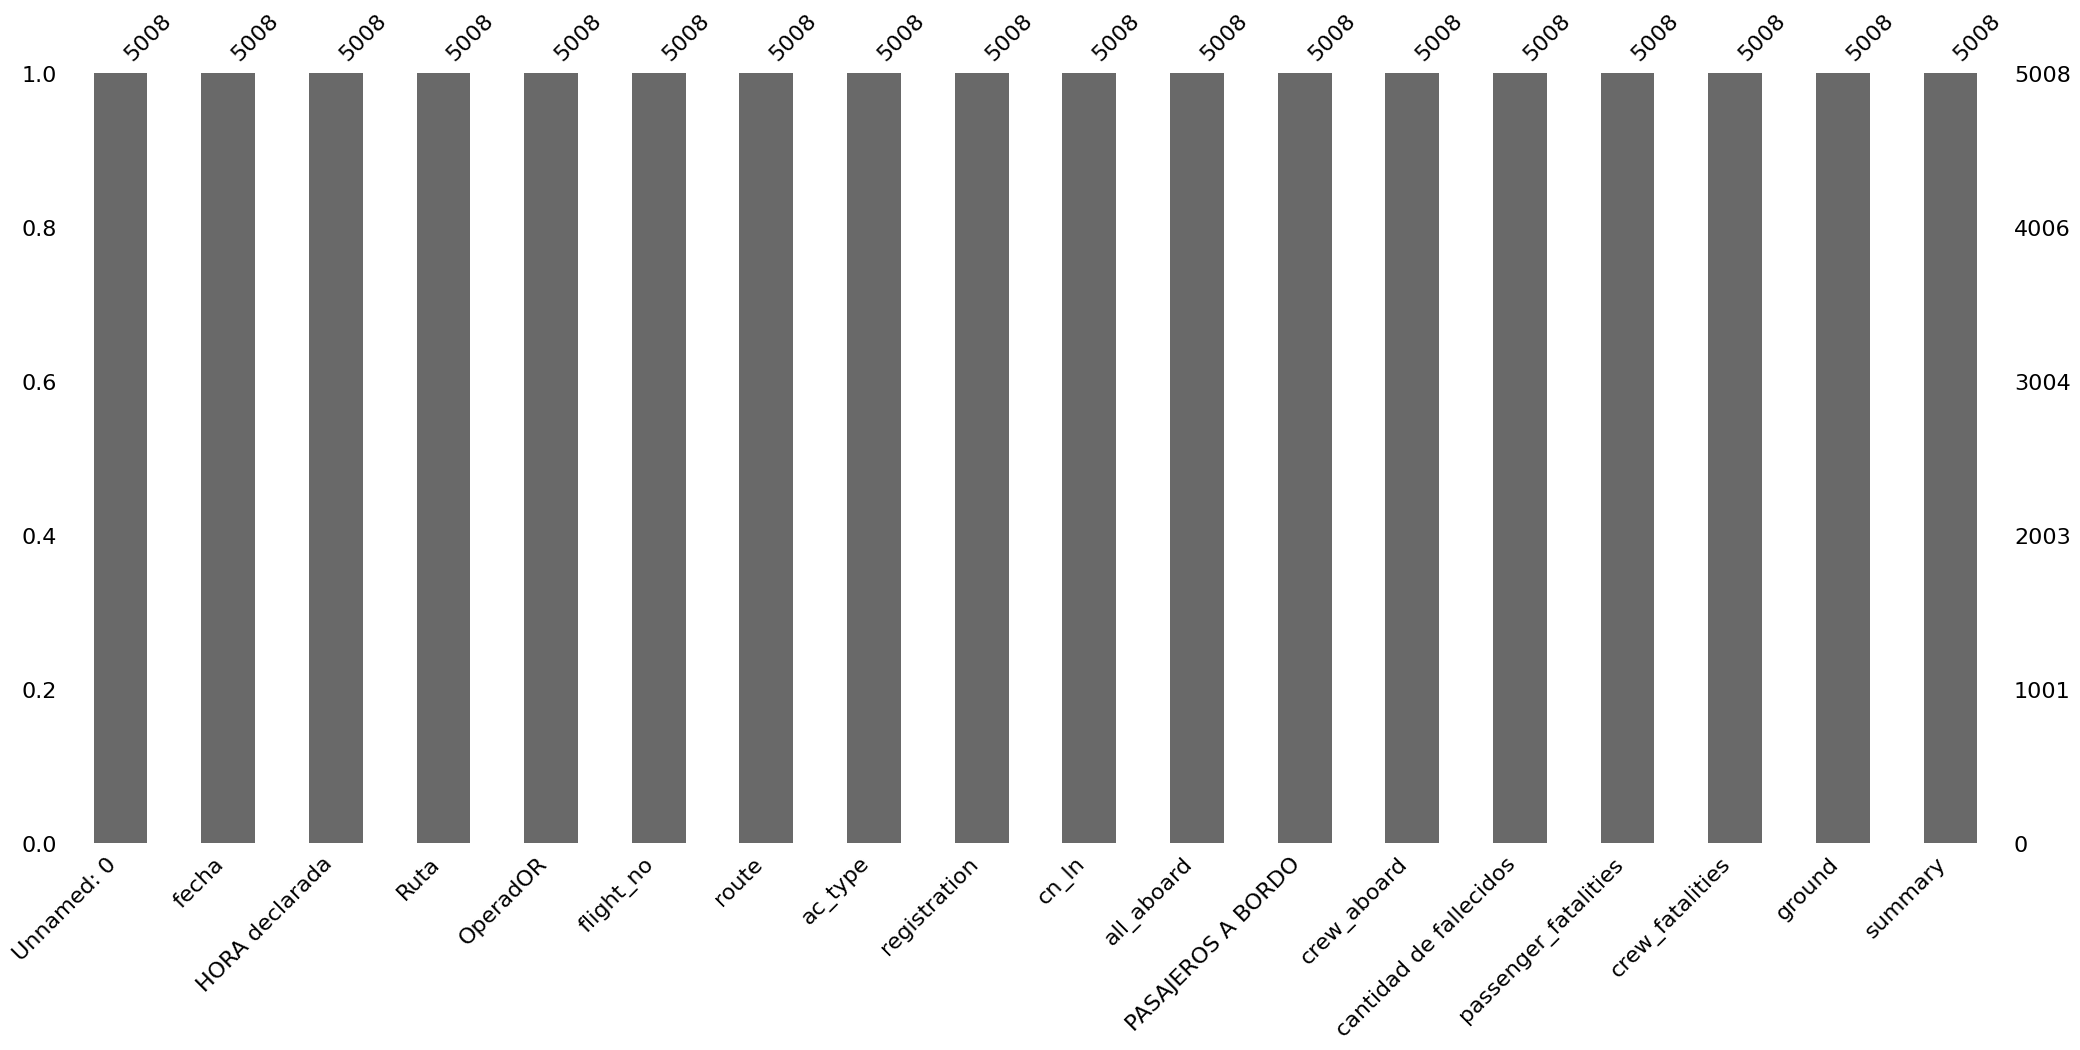

In [36]:
# We will use the missingno library to see the null values in an illustrative way.

msno.bar(crashes)
plt.show()

In [37]:
crashes.columns

Index(['Unnamed: 0', 'fecha', 'HORA declarada', 'Ruta', 'OperadOR',
       'flight_no', 'route', 'ac_type', 'registration', 'cn_ln', 'all_aboard',
       'PASAJEROS A BORDO', 'crew_aboard', 'cantidad de fallecidos',
       'passenger_fatalities', 'crew_fatalities', 'ground', 'summary'],
      dtype='object')

In [38]:
# Normalizing the names of the columns.
crashes.rename(columns={'fecha': 'date', 'HORA declarada':'time', 'Ruta': 'crash_site', 'OperadOR' : 'operator', 'route': 'route_flight_type','all_aboard' : 'people_on_board', 'PASAJEROS A BORDO' : 'passengers_on_board', 
                        'cantidad de fallecidos' : 'fatalities'}, inplace=True)

# Reordering and filtering the desired columns.
crashes = crashes[['date', 'time', 'crash_site', 'operator', 'flight_no', 'route_flight_type', 'ac_type', 'registration', 'cn_ln', 'people_on_board', 'crew_aboard',
       'passengers_on_board', 'fatalities',  'crew_fatalities', 'passenger_fatalities', 'ground', 'summary']]

# We delete the column Unnamed: 0 as we do not need it.

### Missing values

In [39]:
# One of the first steps in an EDA is to know how many missing values we have in each feature. With a for cycle we find this.
# It is important to know that in this dataset the character '?' represents a missing value.
for i in crashes.columns:
    print('The number of missing values for', i, 'is:', (crashes[crashes[i] == '?'].shape[0]))

The number of missing values for date is: 0
The number of missing values for time is: 1504
The number of missing values for crash_site is: 5
The number of missing values for operator is: 10
The number of missing values for flight_no is: 3682
The number of missing values for route_flight_type is: 762
The number of missing values for ac_type is: 13
The number of missing values for registration is: 272
The number of missing values for cn_ln is: 667
The number of missing values for people_on_board is: 17
The number of missing values for crew_aboard is: 219
The number of missing values for passengers_on_board is: 221
The number of missing values for fatalities is: 8
The number of missing values for crew_fatalities is: 235
The number of missing values for passenger_fatalities is: 235
The number of missing values for ground is: 44
The number of missing values for summary is: 59


In [40]:
# Checking for duplicated records. There are no replicated records.
crashes.duplicated().value_counts()

False    5008
dtype: int64

#### Columns date and declared_time

In [41]:
# To change the record to a datetime format we are going to combined with the colum declared_time to extract the information needed.

In [42]:
# Using regular expression and lambda functions we are going to obtain the numerical part of the record in the column time
# avoiding other characters. In case that the records is not a number we are going to set it as 00:00
de_time = crashes.time.apply(lambda x: re.search('\d+|\d+:+\d+', x).group () if re.search('\d+|\d+:+\d+', x) else '00:00')
crashes['time'] = de_time

In [43]:
# Depending on the lenght of the record in the column time we are going to execute different actions.
# If the record has 5 character we are going to leave it as it is.
# If the record has 1, 2 or 4 charactes we are going to add : or :00 when neccesary.
# If the record has 3 characters we are going modify the record to the aproppiate form.
# All of this is done using slicing, if function and a for cycle.
for i, j in enumerate(crashes.time):
    if j != None:
        
        if len(j) == 5:
            continue
        elif 1 <= len(j) <= 2:
            number = j + ':' + '00'
            crashes.time[i] = number
        elif len(j) == 3:
            if int(j[0:2]) <= 24 and int(j[1:]) < 60:
                number = j[0] + ':' + j[1:]
                crashes.time[i] = number
            elif int(j[0:2]) <= 24 and int(j[1:]) > 60:
                number = j[0:2] + ':' + j[2] + '0'
                crashes.time[i] = number
            elif int(j[0:2]) > 24 and int(j[1:]) < 60:
                number = j[0] + ':' + j[1:]
                crashes.time[i] = number     
        elif len(j) == 4:
            number = j[0:2] + ':' + j[2:4]
            crashes.time[i] = number

In [44]:
# Creation of a column with the date and time of the flight accident.
crashes['date_time'] = crashes.apply(lambda x: (str(x['date']) + ' '+ x['time']) , axis=1)

In [45]:
# Obtaining the date and time of the crashes.
date_time = crashes.date_time.apply(lambda x: datetime.strptime(x, '%B %d, %Y %H:%M'))
crashes['date_time'] = date_time

In [46]:
# Assingning the transformed records in the colums date and time.
just_date = crashes['date_time'].apply(lambda x: x.date())
crashes['date'] = just_date

just_time = crashes['date_time'].apply(lambda x: x.time())
crashes['time'] = just_time

# And deleting the created auxiliar colum date_time
crashes.drop('date_time', axis=1, inplace=True)

In [ ]:
# # Relativedelta is a tool used to obtain the difference period of time in which the accidentes happened:
print('The temporal window of the data is from', crashes.date.min(), 'to', crashes.date.max(), 'around', relativedelta(crashes.date.max(), crashes.date.min()).years, 'years')

In [48]:
# Checkpoint df
df = crashes

#### people_on_board, crew_aboard, passengers_on_board, fatalities, crew_fatalities and passenger_fatalities

In [50]:
# In order to inpute the missing values of people_on_board we are going to transform the columns crew_aboard, passengers_on_board, 
# fatalities, crew_fatalities and passenger_fatalities.

# We create a dataset replacing the missing values '?' for a 0 in this columns in order to compute some operations.
modify_df = crashes.apply(lambda x: x.replace('?','0'))

In [51]:
# For the column passengers_on_board we are going to inpute the sum of the values of crew_aboard and passengers_on_board in case its values is 0.
# We do this using the apply and lambda function.
passengers_on_board = modify_df.apply(lambda x: (int(x['crew_aboard']) + int(x['passengers_on_board'])) if x['people_on_board'] == '0' else x['people_on_board'], axis=1)
crashes['people_on_board'] = passengers_on_board

# For the column fatalities we are going to inpute the sum of the values of crew_fatalities and passenger_fatalities in case its values is 0.
# We do this using the apply and lambda function.
fatalities = modify_df.apply(lambda x: (int(x['crew_fatalities']) + int(x['passenger_fatalities'])) if x['fatalities'] == '0' else x['fatalities'], axis=1)
crashes['fatalities'] = fatalities

# We are going to assume that the fatalities number is the people who died in the flight. Therefore, if the number of fatalities is higher than the number of people on board,
# we will replace the record in people_on_board for the fatalities record. We will do this using the apply and lambda function.
passengers_on_board = modify_df.apply(lambda x: x['fatalities'] if x['people_on_board'] < x['fatalities'] else x['people_on_board'], axis=1)
crashes['people_on_board'] = passengers_on_board

# If we still have records with 0s in people_on_board we assume that it was a triupulated flight so at least one person was on the flight.
passengers_on_board = modify_df.apply(lambda x: 1 if x['people_on_board'] == '0' else x['people_on_board'], axis=1)
crashes['people_on_board'] = passengers_on_board

In [52]:
# We change the type of data to integers for several columns in order to work with them.
crashes = crashes.apply(lambda x: x.replace('?','0'))
crashes['people_on_board'] = crashes['people_on_board'].astype('int64')
crashes['crew_aboard'] = crashes['crew_aboard'].astype('int64')
crashes['passengers_on_board'] = crashes['passengers_on_board'].astype('int64')
crashes['fatalities'] = crashes['fatalities'].astype('int64')
crashes['crew_fatalities'] = crashes['crew_fatalities'].astype('int64')
crashes['passenger_fatalities'] = crashes['passenger_fatalities'].astype('int64')
crashes['ground'] = crashes['ground'].astype('int64')


In [53]:
# Checkpoint df
df2 = crashes

### Geographical information.

In [56]:
# Using the crash_site of the accidents we are going to retrieve geographic information when possible. Using Geopy we will locate the coordinates of addresses, cities, countries,
# and landmarks across the globe using third-party geocoders and other data sources.
# This will be set on a function to obtain the needed data.

def geolocator(site):
    from geopy.geocoders import Nominatim
    geolocator = Nominatim(user_agent="MyApp")
    location = geolocator.geocode(site)
    return location.latitude, location.longitude

In [57]:
# Descartado inicialmente
# Normalizing the column crash_site to obtain the coordinates of the several locations.
crash_sites = list(crashes.crash_site.apply(lambda x: x.replace('Near ', '').replace('Dakar, ','').replace('Over ', '').replace('110 miles SW of ', '').replace('1,200 miles off ', '').
                                                     replace('125 miles ENE of ', '').replace('175 miles off ', '').replace('200 miles NE of ', '').replace('25 nm off ', '').
                                                     replace('250 miles northwest of ', '').replace('300 nm NW of ', '').replace('81 miles SW o f', '').replace('900 miles E of ', '').
                                                     replace('950 nm S of  ', '').replace('Over ', '').replace('near ', '').replace('off ', '').replace('Off ', '').title()).sort_values().unique())

# Additional normalization
crash_sites[0] = 'Domodedovo, Russia'
crash_sites[1] = 'Kathmandu, Nepal'
crash_sites[2] = 'Novosibirsk, Russia'
crash_sites[3] = 'Zugdidi, Georgia'

# Sorting the elements of the list with the unique locations of the accidents.
crash_sites.sort()
crash_sites


[' Libreville, Gambia',
 ' Macaé , Rio De Janeiro , Brazil',
 ' Mackay, Qld. Australia',
 ' Novosibirsk, Russia',
 ' Zugdidi, Georgia',
 '0',
 'Aarsele, West Vlaanderen, Belgium',
 'Abakan, Russia',
 'Abakan, Siberia, Russia',
 'Abeokuta, Nigeria',
 'Aberdeen, South Dakota',
 'Abidjan, Ivory Coast',
 'Abilene, Texas',
 'Abruzzio Mountains, Italy',
 'Abu Adh Dhuhur Air Base, Syria',
 'Abuja, Nigeria',
 'Abéché, Chad',
 'Accra, Ghana',
 'Adak, Alaska',
 'Adar Yeil, Sudan',
 'Adar, Russia',
 'Addis Ababa, Ethiopia',
 'Adelaide Hills, Australia',
 'Aden, Yemen',
 'Adler, Russia',
 'Adler, Ussr',
 'Adler, Washington',
 'Adraskan District, Afghanistan',
 'Aegean Sea',
 'Afghanistan',
 'Agadir, Morocco',
 'Agana, Guam',
 'Agana, Guam, Mariana Islands',
 'Agartala, India',
 'Agra, India',
 'Agrigento, Italy',
 'Agudos, Brazil',
 'Aguelhok, Mali',
 'Agustin Codazzi, Colombia',
 'Ahmedabad, India',
 'Ain Kercha, Algeria',
 'Ajaccio, Corsica, France',
 'Ajaccio, France',
 'Akkajaure Lake, Norrbot

In [59]:
# # Column to validate the results. V2
crashes['crash_site_clean'] = crashes.crash_site.apply(lambda x: x.lower().replace('near ', '').replace('dakar, ','').replace('over ', '').replace('110 miles sw of ', '').replace('1,200 miles off ', '').
                                                     replace('125 miles ene of ', '').replace('175 miles off ', '').replace('200 miles ne of ', '').replace('25 nm off ', '').
                                                     replace('250 miles northwest of ', '').replace('300 nm nw of ', '').replace('81 miles sw o f', '').replace('900 miles e of ', '').
                                                     replace('950 nm s of  ', '').replace('over ', '').replace('near ', '').replace('off ', '')) # ADD north of , south of, east of, west of 
crash_sites = crashes.crash_site #175 miles off the Over the Gulf of


In [60]:
# Function to clean records from information that make noise. V2
def normalizing(record):
    data = record.lower().replace('near ', '').replace('dakar, ','').replace('over ', '').replace('110 miles sw of ', '').replace('1,200 miles off ', '').replace('125 miles ene of ', '').replace('175 miles off ', '').replace('200 miles ne of ', '').replace('25 nm off ', '').replace('250 miles northwest of ', '').replace('300 nm nw of ', '').replace('81 miles sw o f', '').replace('900 miles e of ', '').replace('950 nm s of  ', '').replace('over ', '').replace('near ', '').replace('off ', '')
    return data # ADD north of , south of, east of, west of 175 miles off the Over the Gulf of

In [63]:
# for cicle to obtain the latitude and longitude of the unique locations of flight accidents. 
# The unique locations go through the location geolocator to obtain the geographic coordinates.
# In each istance the latitude and longitude will be add to lists in order to construct a auxilar dataframe with this information.
latitude = []
longitude = []
crash_site_clean_l = []
for index, site in enumerate(crash_sites):
    normalized = normalizing(site) #In case using the normalizing function we will have to change the site for normalized
    try:
        if site == '0':
            latitude.append('No info')
            longitude.append('No info')
            crash_site_clean_l.append('0')
            print('Could not obtain geographic information for:', normalized)
            
        elif site != '0':
            if normalized == ' Domodedovo, Russia':
                crashes['crash_site'][index] = 'Domodedovo, Russia'
                normalized = 'Domodedovo, Russia'

            elif normalized == ' Kathmandu, Nepal':
                crashes['crash_site'][index] = 'Kathmandu, Nepal'
                normalized = 'Kathmandu, Nepal'

            elif normalized == ' Novosibirsk, Russia':
                crashes['crash_site'][index] = 'Novosibirsk, Russia'
                normalized = 'Novosibirsk, Russia'
                
            elif normalized == ' Zugdidi, Georgia':
                crashes['crash_site'][index] = 'Zugdidi, Georgia'
                normalized = 'Zugdidi, Georgia'     
               
            latitude_site, longitude_site = geolocator(normalized)
            latitude.append(latitude_site)
            longitude.append(longitude_site)
            crash_site_clean_l.append(normalized)
            print('Succesfull geographic information for:', normalized)
        
    except:
        latitude.append('No info')
        longitude.append('No info')
        crash_site_clean_l.append(normalized)
        print('Error with:', normalized)
        
# First time 41 min
# Last time 48 min

Succesfull geographic information for: fort myer, virginia
Succesfull geographic information for: juvisy-sur-orge, france
Succesfull geographic information for: atlantic city, new jersey
Succesfull geographic information for: victoria, british columbia, canada
Succesfull geographic information for: the north sea
Succesfull geographic information for: johannisthal, germany
Succesfull geographic information for: tienen, belgium
Succesfull geographic information for: cuxhaven, germany
Error with: jambol, bulgeria
Succesfull geographic information for: billericay, england
Succesfull geographic information for: potters bar, england
Succesfull geographic information for: mainz, germany
Succesfull geographic information for: west hartlepool, england
Succesfull geographic information for: gent, belgium
Succesfull geographic information for: northern germany
Error with: texel island, north sea
Error with: vlieland island, north sea
Succesfull geographic information for: yarmouth, england
Succes

In [65]:
# Creation of an auxiliary dataset constructed with the lists from the previous step.
locations = pd.DataFrame({'location':crash_site_clean_l, 'latitude':latitude, 'longitude':longitude})

In [71]:
# Saving an additional file with coordinates
locations.to_csv('data_coordinates.csv', index=False)

In [73]:
# After completing the geographic information we still have some locations with no latitude and longitude data.
locations[locations.latitude == 'No info'].shape

(883, 3)

In [74]:
# For cicle to inpute the values from the auxiliary dataframe to the main dataframe.

crashes['latitude'] = 0
crashes['longitude'] = 0
crashes['confirmation'] = 0
n = 0
for i, j in enumerate(crashes.crash_site_clean):
    for k, l in enumerate(locations.location):
        if j == l:
            crashes['latitude'][i] = locations.latitude[k]
            crashes['longitude'][i] = locations.longitude[k]
            crashes['confirmation'][i] = locations.location[k]
            n += 1
            break
print(n)

C:\Users\Oscar Marino\AppData\Local\Temp\ipykernel_16064\1473782826.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes['latitud'][i] = locations.latitude[k]
C:\Users\Oscar Marino\AppData\Local\Temp\ipykernel_16064\1473782826.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes['longitude'][i] = locations.longitude[k]
C:\Users\Oscar Marino\AppData\Local\Temp\ipykernel_16064\1473782826.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

5008


In [81]:
# Checkpoint df
df3 = crashes

In [89]:
# 2nd cycle to obtain addditional coordinates using a section of the site. In these cases, the geographiic coordinate wiil be more general,
# nevertheless, it is more precise than not having information.
for index, site in enumerate(crashes.latitude):
    if site == 'No info':
        
        try:
        
            if crashes.crash_site_clean[index] == '0':
                continue
            
            elif site:
                crash = crashes.crash_site_clean[index]
                comas = 0
                for char in crash:
                    if char == ',':
                        comas += 1
                
                if comas == 1:
                    city, country = crash.split(',')
                    latitude_site, longitude_site = geolocator(country)
                    crashes['latitude'][index] = latitude_site
                    crashes['longitude'][index] = longitude_site
                    print('Succesfull geographic information for:', crash, 'using the country')
                    
                elif comas == 2:
                    city, state, country = crash.split(',')
                    try:
                        place = city + ' ' + country
                        latitude_site, longitude_site = geolocator(place)
                        crashes['latitude'][index] = latitude_site
                        crashes['longitude'][index] = longitude_site
                        print('Succesfull geographic information for:', crash, 'using the city and country')
                    except:
                        try:
                            place = state + ' ' + country
                            latitude_site, longitude_site = geolocator(place)
                            crashes['latitude'][index] = latitude_site
                            crashes['longitude'][index] = longitude_site
                            print('Succesfull geographic information for:', crash, 'using the state and country')
                        except:
                            print('Could not recover geographic info for', crash)
        except:
            print('Could not recover geographic info for', index, crashes.crash_site_clean[index])
            
# It takes around 10 mins

Could not recover geographic info for 51 mendotta, minnisota


C:\Users\Oscar Marino\AppData\Local\Temp\ipykernel_16064\311964125.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes['latitude'][index] = latitude_site
C:\Users\Oscar Marino\AppData\Local\Temp\ipykernel_16064\311964125.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes['longitude'][index] = longitude_site


Succesfull geographic information for: murchinson river, australia using the country


C:\Users\Oscar Marino\AppData\Local\Temp\ipykernel_16064\311964125.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes['latitude'][index] = latitude_site
C:\Users\Oscar Marino\AppData\Local\Temp\ipykernel_16064\311964125.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes['longitude'][index] = longitude_site


Succesfull geographic information for: amiens, picrdie, france using the city and country
Succesfull geographic information for: east mallling, united kingdom using the country


C:\Users\Oscar Marino\AppData\Local\Temp\ipykernel_16064\311964125.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes['latitude'][index] = latitude_site
C:\Users\Oscar Marino\AppData\Local\Temp\ipykernel_16064\311964125.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes['longitude'][index] = longitude_site


Succesfull geographic information for: tiflis, georgia, ussr using the state and country
Succesfull geographic information for: rossaugpt, czechoslovakia using the country
Could not recover geographic info for leigh, kent, unied kingdom
Succesfull geographic information for: thies, mauritania using the country
Succesfull geographic information for: port townsend, bc, canada using the state and country
Succesfull geographic information for: heroldbach, germany using the country
Succesfull geographic information for: mt. taylor, grants, new mexico using the city and country
Could not recover geographic info for 210 terranova pausania, east sardinia
Succesfull geographic information for: brawnson, nebraska using the country
Succesfull geographic information for: iglau, czechoslovakia using the country
Succesfull geographic information for: la rache, morocco using the country
Succesfull geographic information for: techachapi mountains, california using the country
Succesfull geographic inf

In [91]:
# From 883 records with no geographic information we only have 103 now.
crashes[crashes.latitude == 'No info'].shape[0]

103

In [ ]:
# Checkpoint df
df4 = crashes

#### Continents

In [76]:
# This line tells python to throw the installation outputs into the throwaway variable _
_ = !pip install geopy pycountry-convert tqdm -q

In [77]:
# Usign geopy we are going to check in which continent the accidents happened, as the library allows to locate the coordinates of addresses, cities, countries,
# and landmarks across the globe using third-party geocoders and other data sources.

In [78]:
# Function that maps the code to the corresponding full name of the continent.
def get_continent_name(continent_code):
    continent_dict = {
        "NA": "North America",
        "SA": "South America",
        "AS": "Asia",
        "AF": "Africa",
        "OC": "Oceania",
        "EU": "Europe",
        "AQ" : "Antarctica"
    }
    return continent_dict[continent_code]

In [86]:
def get_continent(lat, lon):
    try:
        # Nominatim is a geocoding service that powers the library.
        geolocator = Nominatim(user_agent="<username>@gmail.com", timeout=10)
        geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1)

        location = geocode(f"{lat}, {lon}", language="en")

        # for cases where the location is not found, coordinates are antarctica or the seven seas. In the case of a seaa we will change that later.
        if location is None:
            return "Antarctica", "Antarctica"

        # extract country code and country name
        address = location.raw["address"]
        country_code = address["country_code"].upper()
        country_name = address['country'].upper()

        # get continent code from country code
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_name = get_continent_name(continent_code)
        
        return country_name, continent_name
    except:
        return 'No info', 'No info'

In [87]:
# Using a lambda function we are goint to apply the previous functions to obtain the country name and continent.
crashes[["country", "continent"]] = crashes.progress_apply(lambda x: get_continent(x["latitude"], x["longitude"]), axis=1, result_type="expand")

100%|██████████| 5008/5008 [47:00<00:00,  1.78it/s]  


In [101]:
# Normalizing the format of the column country
crashes.country = crashes.country.apply(lambda x: x.title())

C:\Users\Oscar Marino\AppData\Local\Temp\ipykernel_21236\2561379974.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes.country = crashes.country.apply(lambda x: x.title())


In [91]:
# Dataframe checkpoint
df4 = crashes

#### Designation of day time

In [144]:
crashes['time_of_day'] = 0
for index, time in enumerate(crashes.time):
    if time == datetime.strptime('00:00:00', '%H:%M:%S').time():
        time_of_day = 'No info'
        crashes['time_of_day'][index] = time_of_day
    
    elif datetime.strptime('00:00:00', '%H:%M:%S').time() < time <  datetime.strptime('05:00:00', '%H:%M:%S').time():
        time_of_day = 'Early morning'
        crashes['time_of_day'][index] = time_of_day
        
    elif datetime.strptime('05:00:00', '%H:%M:%S').time() <= time <  datetime.strptime('12:00:00', '%H:%M:%S').time():
        time_of_day = 'Morning'
        crashes['time_of_day'][index] = time_of_day
    
    elif datetime.strptime('12:00:00', '%H:%M:%S').time() <= time <  datetime.strptime('18:00:00', '%H:%M:%S').time():
        time_of_day = 'Afternoon'
        crashes['time_of_day'][index] = time_of_day
    
    elif datetime.strptime('18:00:00', '%H:%M:%S').time() <= time <  datetime.strptime('23:59:59', '%H:%M:%S').time():
        time_of_day = 'Evening'
        crashes['time_of_day'][index] = time_of_day

C:\Users\Oscar Marino\AppData\Local\Temp\ipykernel_16064\369501516.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes['time_of_day'][index] = time_of_day


#### Imputing some type of flights

In [199]:
# Function to assing the the type of flight.
def flight_type_f(record):
    list_flight_type = ['military', 'military', 'military', 'military', 'military', 'military','comercial', 'comercial', 'comercial', 'comercial', 'comercial', 'comercial', 'comercial', 'comercial', 'mailing services','mailing services']
    options = ['military', 'navy', 'force', 'air force', 'self-defence', 'military - ', 'airlines', 'air lines', 'airways', 'air ways', 'aeroflot', 'private', 'satena', 'charter', 'air cargo', 'cargo']
    for i, j in enumerate(options):
        if j in record:
            flight_type = list_flight_type[i].title()
            break
        else:
            flight_type = 'No info'
    return flight_type

# Creating a column with the type of flight.
crashes['flight_type'] = crashes.apply(lambda x: flight_type_f(x['operator'].lower()), axis =1)

In [202]:
crashes.columns

Index(['date', 'time', 'time_of_day', 'crash_site', 'country', 'continent',
       'latitude', 'longitude', 'operator', 'flight_no', 'route_flight_type',
       'ac_type', 'registration', 'cn_ln', 'people_on_board', 'crew_aboard',
       'passengers_on_board', 'fatalities', 'crew_fatalities',
       'passenger_fatalities', 'ground', 'summary', 'flight_type'],
      dtype='object')

In [95]:
# Reordering the dataframe to check the results from the previous steps.
crashes = crashes[['date', 'time', 'time_of_day','crash_site', 'country', 'continent','crash_site_clean', 'latitude', 'longitude', 'operator','flight_type', 'flight_no',
                     'route_flight_type', 'ac_type', 'registration', 'cn_ln',
                     'people_on_board', 'crew_aboard', 'passengers_on_board', 'fatalities',
                     'crew_fatalities', 'passenger_fatalities', 'ground', 'summary'
                     ]]

# We delete the column crash_site_clean because we do not need it anymore.
crashes.drop('crash_site_clean', axis=1, inplace=True)

C:\Users\Oscar Marino\AppData\Local\Temp\ipykernel_16064\3583126579.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes.drop('crash_site_clean', axis=1, inplace=True)


In [ ]:
# This line of code should not be executed. In case that at the end the date and time columns are not in the correct type of data execute it.

# auxiliar = pd.read_csv('AccidentesAviones.csv')
# auxiliar.drop('Unnamed: 0', axis=1,inplace=True)

# auxiliar.rename(columns={'fecha': 'date', 'HORA declarada':'time', 'Ruta': 'crash_site', 'OperadOR' : 'operator', 'route': 'route_flight_type','all_aboard' : 'people_on_board', 'PASAJEROS A BORDO' : 'passengers_on_board', 
#                         'cantidad de fallecidos' : 'fatalities'}, inplace=True)

# auxiliar = auxiliar[['date', 'time', 'crash_site', 'operator', 'flight_no', 'route_flight_type', 'ac_type', 'registration', 'cn_ln', 'people_on_board', 'crew_aboard',
#        'passengers_on_board', 'fatalities',  'crew_fatalities', 'passenger_fatalities', 'ground', 'summary']]

# de_time = auxiliar.time.apply(lambda x: re.search('\d+|\d+:+\d+', x).group () if re.search('\d+|\d+:+\d+', x) else '00:00')
# auxiliar['time'] = de_time

# for i, j in enumerate(auxiliar.time):
#     if j != None:
        
#         if len(j) == 5:
#             continue
#         elif 1 <= len(j) <= 2:
#             number = j + ':' + '00'
#             auxiliar.time[i] = number
#         elif len(j) == 3:
#             if int(j[0:2]) <= 24 and int(j[1:]) < 60:
#                 number = j[0] + ':' + j[1:]
#                 auxiliar.time[i] = number
#             elif int(j[0:2]) <= 24 and int(j[1:]) > 60:
#                 number = j[0:2] + ':' + j[2] + '0'
#                 auxiliar.time[i] = number
#             elif int(j[0:2]) > 24 and int(j[1:]) < 60:
#                 number = j[0] + ':' + j[1:]
#                 auxiliar.time[i] = number     
#         elif len(j) == 4:
#             number = j[0:2] + ':' + j[2:4]
#             auxiliar.time[i] = number
            
# auxiliar['date_time'] = auxiliar.apply(lambda x: (str(x['date']) + ' '+ x['time']) , axis=1)

# date_time = auxiliar.date_time.apply(lambda x: datetime.strptime(x, '%B %d, %Y %H:%M'))
# auxiliar['date_time'] = date_time

# just_date = auxiliar['date_time'].apply(lambda x: x.date())
# auxiliar['date'] = just_date

# just_time = auxiliar['date_time'].apply(lambda x: x.time())
# auxiliar['time'] = just_time


# auxiliar.drop('date_time', axis=1, inplace=True)
# print('The temporal window of the data is from', auxiliar.date.min(), 'to', auxiliar.date.max(), 'around', relativedelta(auxiliar.date.max(), auxiliar.date.min()).years, 'years')

# aa = auxiliar.date
# crashes['date'] = aa

# bb = auxiliar.time
# crashes['time'] = bb

In [141]:
# Checkpoint df
df5 = crashes

In [203]:
# Saving the dataset after all the transformation.
crashes.to_csv('crashes_modify.csv')